<a href="https://colab.research.google.com/github/Elman295/Multi-Modal-Unet-for-change-Detection/blob/main/Multi_Modal_Unet_for_Change_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 22.7 MB/s eta 0:00:00


In [1]:
! pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 24.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=c15bf7533334968dfd4471b11ef8beced85db7f716da4cd425e3893fdb1e6275
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=ed07f4c0c78d20fb6fd6812a1597b29088e8d36d249535c14049cfce6f272899
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c601

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from sklearn.model_selection import train_test_split
from PIL import Image
import segmentation_models_pytorch as smp

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torchmetrics

#`Data Exploration`

In [3]:
data_path = os.path.join("drive", "MyDrive","DATA","train.zip")

In [4]:
with zipfile.ZipFile(data_path,"r") as f:
  f.extractall("data")

In [5]:
A_path = os.path.join("data","A")
B_path = os.path.join("data","B")
label_path = os.path.join("data","label")

In [6]:
len(os.listdir(A_path))

445

In [7]:
tfms_label = transforms.Compose([
    transforms.Resize(size = (128,128)),
    transforms.ToTensor()
])

In [8]:
class Data_Generator(Dataset):

  def __init__(self, A_file, B_file, label_file, tfms = None):

    self.A_file = A_file
    self.B_file = B_file
    self.label_file = label_file
    self.tfms = tfms

  def __len__(self):

    return len(os.listdir(self.A_file))

  def __getitem__(self, idx):

    A_image_path = os.path.join(self.A_file,f"train_{idx+1}.png")
    B_image_path = os.path.join(self.B_file,f"train_{idx+1}.png")
    label_image_path = os.path.join(self.label_file,f"train_{idx+1}.png")

    A_image = Image.open(A_image_path).convert("RGB")
    B_image = Image.open(B_image_path).convert("RGB")
    label_image = Image.open(label_image_path)
    label_image = tfms_label(label_image)

    if self.tfms is not None:

      A_image = self.tfms(A_image)
      B_image = self.tfms(B_image)


    return A_image, B_image, torch.tensor(label_image).long()



In [9]:
tfms = transforms.Compose([
    transforms.Resize(size = (128,128)),
    transforms.ToTensor()
])

In [10]:
data_ds = Data_Generator(A_path, B_path, label_path,tfms)

<ipython-input-8-bac423d7f8ab>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return A_image, B_image, torch.tensor(label_image).long()


torch.Size([1, 128, 128])


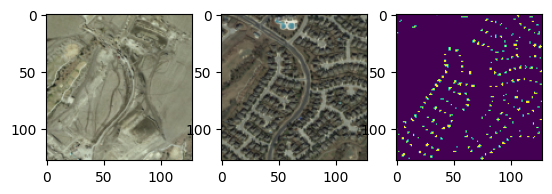

In [11]:
pre,post,label = data_ds[230]

print(label.shape)

plt.subplot(1,3,1)
plt.imshow(pre.permute(1,2,0))
plt.subplot(1,3,2)
plt.imshow(post.permute(1,2,0))
plt.subplot(1,3,3)
plt.imshow(label.permute(1,2,0))

plt.show()

In [12]:
train_ds, test_ds = train_test_split(data_ds, test_size = 0.2, shuffle = True)

<ipython-input-8-bac423d7f8ab>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return A_image, B_image, torch.tensor(label_image).long()


In [13]:
len(train_ds)

356

In [14]:
len(test_ds)

89

In [41]:
train_dl = DataLoader(dataset = train_ds, batch_size = 16, shuffle=True)
test_dl =  DataLoader(dataset = test_ds, batch_size = 16, shuffle=True)

In [16]:
pre,post,label = next(iter(train_dl))
print(pre.shape)
print(post.shape)
print(label.shape)

torch.Size([16, 3, 128, 128])
torch.Size([16, 3, 128, 128])
torch.Size([16, 1, 128, 128])


In [17]:
label

tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 1, 1, 1]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        ...,


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
         

In [18]:
label.max()

tensor(1)

#`Multi-Modal Unet`

In [19]:
unet_1 = smp.Unet(in_channels=3, classes = 2)
unet_2 = smp.Unet(in_channels=3, classes = 2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 230MB/s]


In [20]:
class Multi_Modal(nn.Module):

  def __init__(self,unet_1, unet_2):
    super(Multi_Modal, self).__init__()
    self.unet_1 = unet_1
    self.unet_2 = unet_2

  def forward(self,I1,I2):
    f1 = self.unet_1(I1)
    f2 = self.unet_2(I2)
    f = f1 + f2
    return f

In [21]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [22]:

model = Multi_Modal(unet_1, unet_2).to(device)
x = torch.rand(size = (16,3,128,128)).to(device)
y = model(x,x)
print(y.shape)

torch.Size([16, 2, 128, 128])


#`Other`

In [23]:
opt = torch.optim.Adam(params = model.parameters(), lr = 1e-3)
loss_fn = nn.CrossEntropyLoss()

In [25]:
def train(data, model, opt, loss_fn):

  model.train()
  size = len(data.dataset)

  for b , (i1,i2,label) in enumerate(data):

    i1,i2 = i1.to(device), i2.to(device)
    label = label.to(device)


    label = label.reshape(-1,128,128)


    y_pred = model(i1,i2)
    loss = loss_fn(y_pred, label)
    opt.zero_grad()
    loss.backward()
    opt.step()

    if b % 100 == 0:
      print(f"loss:{loss.item()} [{len(i1)*b} | {size}]")


In [45]:
for e in range(10):
  print(f"epoch:{e +1}=-=-=-=")
  train(train_dl, model, opt, loss_fn)

epoch:1=-=-=-=
loss:0.023147059604525566 [0 | 356]
epoch:2=-=-=-=
loss:0.007531516253948212 [0 | 356]
epoch:3=-=-=-=
loss:0.012402491644024849 [0 | 356]
epoch:4=-=-=-=
loss:0.015375522896647453 [0 | 356]
epoch:5=-=-=-=
loss:0.018357422202825546 [0 | 356]
epoch:6=-=-=-=
loss:0.02144329436123371 [0 | 356]
epoch:7=-=-=-=
loss:0.018067525699734688 [0 | 356]
epoch:8=-=-=-=
loss:0.011168827302753925 [0 | 356]
epoch:9=-=-=-=
loss:0.01242563221603632 [0 | 356]
epoch:10=-=-=-=
loss:0.015336542390286922 [0 | 356]


torch.Size([16, 128, 128])


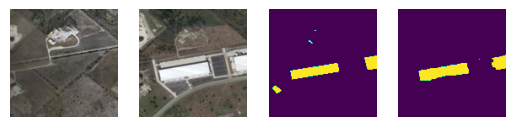

In [60]:
i1,i2,label = next(iter(test_dl))
i1,i2 = i1.to(device), i2.to(device)
model.eval()
with torch.no_grad():
  y_pred = model(i1,i2)
print(y_pred.argmax(1).shape)

plt.subplot(1,4,1)
plt.axis("off")
plt.imshow(i1[0].cpu().permute(1,2,0))

plt.subplot(1,4,2)
plt.axis("off")
plt.imshow(i2[0].cpu().permute(1,2,0))

plt.subplot(1,4,3)
plt.axis("off")
plt.imshow(label[0].permute(1,2,0))

plt.subplot(1,4,4)
plt.axis("off")
plt.imshow(y_pred[0].cpu().argmax(0))

In [49]:

jaccard = torchmetrics.JaccardIndex(task = "multiclass", num_classes=2).to(device)

In [53]:
label = label.to(device)

In [58]:
print(f"IOU: {jaccard(y_pred,label.reshape(-1,128,128))}")

IOU: 0.6555494666099548


In [32]:
y_pred[0].argmax(0).max()

tensor(1, device='cuda:0')

In [33]:
label[0].max()

tensor(1)

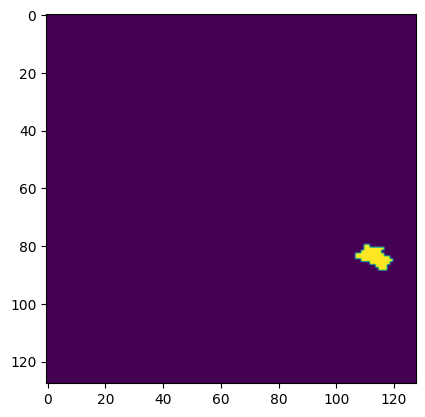

In [35]:
plt.imshow(y_pred[0].cpu().argmax(0))
plt.show()